In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

C:\Users\Tiger\anaconda3\envs\kakao\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


using cached model
using cached model


In [2]:
chatbot_data_short = pd.read_excel('D:\kakao\data\short\한국어_단발성_대화_데이터셋.xlsx')
chatbot_data_continuous = pd.read_excel('D:\kakao\data\continuous\한국어_연속적_대화_데이터셋.xlsx')

len(chatbot_data_short), len(chatbot_data_continuous)

(38594, 55629)

In [3]:
chatbot_data_short['Emotion'].unique(), chatbot_data_continuous['Unnamed: 2'].unique()

(array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object),
 array(['감정', '분노', '혐오', '중립', '놀람', '행복', '공포', '슬픔', 'ㅈ중립', '분ㄴ', '중림',
        nan, 'ㅍ', 'ㄴ중립', '분', '줄'], dtype=object))

In [4]:
chatbot_data_continuous.rename(columns={'Unnamed: 1' : 'Sentence'}, inplace=True)
chatbot_data_continuous.rename(columns={'Unnamed: 2' : 'Emotion'}, inplace=True)

In [5]:
del_list = []
n_list = []
a_list = []

for i, e in enumerate(chatbot_data_continuous['Emotion']):
    if e not in ['감정', '분노', '혐오', '중립', '놀람', '행복', '공포', '슬픔', 'ㅈ중립', '분ㄴ', '중림', 'ㅍ', 'ㄴ중립', '분', '줄']:
        del_list.append(i)
    elif e in ['감정', 'ㅍ']:
        del_list.append(i)
    elif e in ['ㅈ중립', '중림', 'ㄴ중립', '줄']:
        n_list.append(i)
    elif e in ['분ㄴ', '분']:
        a_list.append(i)
        
len(del_list), len(n_list), len(a_list)

(20, 4, 5)

In [6]:
del_list.extend(n_list)
del_list.extend(a_list)

In [7]:
chatbot_data_continuous = chatbot_data_continuous.drop(del_list)

In [8]:
len(chatbot_data_continuous)

55600

In [9]:
chatbot_data_short['Emotion'].unique(), chatbot_data_continuous['Emotion'].unique()

(array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object),
 array(['분노', '혐오', '중립', '놀람', '행복', '공포', '슬픔'], dtype=object))

In [10]:
chatbot_data_short.iloc[:,:2].sample(n=10)

,Sentence,Emotion
34756,정치인들은 다 기회주의자들인거 몰랐냐??,혐오
30566,감사합니다ㆍ,행복
30486,오빠 신인때 야구 하는 모습을 보구 야구를 좋아하게 되었어여,행복
26893,무도가 진심 대단한거지....,중립
28495,멋지다 괴연 세계최고 선진국이다,행복
5682,썸타다가 깨졌는데 갑자기 연락왔어,놀람
36931,일본이 한국호랑이 많이 잡아서 씨를 말리긴했음,혐오
25098,한국은 자연재해나면 정부와 대통령때문이라고 하는 미개한 무식한 것들 많은데 미국은 ...,중립
3092,어떤 방법으로 말을 하면 좋을까요?,공포
4512,고령 운전자분들 운전하시는거 보면 참 불안하지요.,공포


In [11]:
chatbot_data_continuous.iloc[:,1:3].sample(n=10)

,Sentence,Emotion
16608,어.,중립
16777,몰라.,중립
13285,여기서 자고 가면 안 돼요?,슬픔
24011,어..?,놀람
30024,제가 안 괜찮아서 그래요.,분노
34538,"어, 니네 작가 선생이 전화 왔었다.",중립
6473,"넌, 지금의 니 상황이 만족스럽니?",중립
36700,"그럼 어제 그 오빠네 집에서 병간호하면서 밤을 세운거예요, 언니?",놀람
37874,나 기다린거야?,중립
44357,으으으....,중립


In [12]:
chatbot_data = pd.concat([chatbot_data_short.iloc[:,:2], chatbot_data_continuous.iloc[:,1:3]])

In [13]:
chatbot_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
55624,얘긴 다 끝났냐? 원예부,중립
55625,"예. 그거 때문에, 부탁이 있......는......데요.",중립
55626,여자 숨겨달라는거면 사절이다.,중립
55627,아무래도 안되나요?,중립


In [14]:
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

In [15]:
data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

len(data_list)

94194

In [16]:
data_list[:2]

[['언니 동생으로 부르는게 맞는 일인가요..??', '0'], ['그냥 내 느낌일뿐겠지?', '0']]

In [17]:
dataset_train, dataset_val = train_test_split(data_list, test_size=0.15, random_state=42)
dataset_train, dataset_test = train_test_split(dataset_train, test_size=0.10, random_state=42)

In [18]:
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

72057
14130
8007


In [19]:
# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, args):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=args.max_len, pad=args.pad, pair=args.pair)

        self.sentences = [transform([i[args.sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[args.label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [20]:
class BERTClassifier(nn.Module):
    def __init__(self, 
                 bert, 
                 hidden_size=768, 
                 num_classes=7,
                 dr_rate=0.5,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if self.dr_rate:
            self.dropout = nn.Dropout(p=self.dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), 
                              attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [21]:
def train(model, partition, optimizer, loss_fn, args):
    
    train_dataloader = DataLoader(partition['train'], 
                                  batch_size=args.batch_size) #, num_workers=args.num_workers)
    model.train()
    
    correct = 0
    total = 0
    train_loss = 0.0
    
    t_total = len(train_dataloader) * args.num_epochs
    warmup_step = int(t_total * args.warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader, 0):
        optimizer.zero_grad() 
        
        # get the inputs
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    train_loss = train_loss / len(train_dataloader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc

In [22]:
def validate(model, partition, loss_fn, args):
    
    val_dataloader = DataLoader(partition['val'], 
                                 batch_size=args.batch_size) #, num_workers=args.num_workers)
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for token_ids, valid_length, segment_ids, label in val_dataloader:
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            
            loss = loss_fn(out, label)
            
            val_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
    val_loss = val_loss / len(val_dataloader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [23]:
def test(model, partition, args):
    
    test_dataloader = DataLoader(partition['test'], 
                                 batch_size=args.batch_size) #, num_workers=args.num_workers)
    model.eval()
    
    correct = 0
    total = 0
    current_labels = []
    current_preds = []
    
    with torch.no_grad():
        for token_ids, valid_length, segment_ids, label in test_dataloader:
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            current_labels.extend(label)
            current_preds.extend(predicted)
            
    test_acc = 100 * correct / total
    return test_acc, current_labels, current_preds

In [24]:
def experiment(partition, bertmodel, args):
    
    model = BERTClassifier(bertmodel).to(device)
    
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    min_val_loss = np.Inf
    n_epochs_stop = 5
    epochs_no_improve = 0
    early_stop = False
    iter = 0
    
    for epoch in range(args.num_epochs):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args) 
        val_loss, val_acc = validate(model, partition, loss_fn, args) 
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

        if val_loss < min_val_loss:
            # Save the model
            save_model_path = f'./weight/{args.title}.pt' # {str(args.l2).split(".")[1]}-
            torch.save(model.state_dict(), save_model_path) 
            epochs_no_improve = 0
            min_val_loss = val_loss

        else:
            epochs_no_improve += 1
        iter += 1
        if epoch > 4 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue

    test_acc, current_labels, current_preds = test(model, partition, args)
    print('')
    print('Test Accurate Score :', test_acc)
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc

    result['test_labels'] = current_labels
    result['test_preds'] = current_preds

    return vars(args), result

In [25]:
import multiprocessing as mp 
import argparse
from copy import deepcopy

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# ====== Random seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# Setting parameters
args.sent_idx = 0
args.label_idx = 1
args.max_len = 64
args.pad = True
args.pair = False

args.num_workers = 4
args.batch_size = 64

args.warmup_ratio = 0.1
args.num_epochs = 20

args.max_grad_norm = 1

args.log_interval = 100

args.learning_rate =  5e-5

using cached model


In [26]:
data_train = BERTDataset(dataset_train, tok, args)
data_val = BERTDataset(dataset_val, tok, args)
data_test = BERTDataset(dataset_test, tok, args)

partition = {'train': data_train, 'val': data_val, 'test':data_test}

In [27]:
args.title = 'test_0' ### Title !! ###

if __name__ == '__main__':
    mp.freeze_support()
    setting, result = experiment(partition, bertmodel, deepcopy(args))

Epoch 0, Acc(train/val): 57.01/66.43, Loss(train/val) 1.25/0.96. Took 419.73 sec
Epoch 1, Acc(train/val): 68.34/67.59, Loss(train/val) 0.90/0.92. Took 401.22 sec
Epoch 2, Acc(train/val): 71.61/67.90, Loss(train/val) 0.81/0.95. Took 402.45 sec
Epoch 3, Acc(train/val): 74.29/67.62, Loss(train/val) 0.73/1.03. Took 400.65 sec
Epoch 4, Acc(train/val): 76.59/67.66, Loss(train/val) 0.67/1.06. Took 412.97 sec
Epoch 5, Acc(train/val): 78.76/66.92, Loss(train/val) 0.62/1.13. Took 423.95 sec
Epoch 6, Acc(train/val): 81.00/66.39, Loss(train/val) 0.57/1.25. Took 416.77 sec
Early stopping!

Test Accurate Score : 66.09216935181716


In [28]:
print('Train Accurate Score :\t', result['train_acc'])
print('Validate Accurate Score :\t', result['val_acc'])
print('Test Accurate Score :\t', result['test_acc'])

Train Accurate Score :	 80.99560070499743
Validate Accurate Score :	 66.39065817409767
Test Accurate Score :	 66.09216935181716


In [30]:
import re




class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, args):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=args.max_len, pad=args.pad, pair=args.pair)

        self.sentences = [transform([i]) for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i]

    def __len__(self):
        return (len(self.sentences))



class BERTClassifier(nn.Module):
    def __init__(self, 
                 bert, 
                 hidden_size=768, 
                 num_classes=7,
                 dr_rate=0.5,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if self.dr_rate:
            self.dropout = nn.Dropout(p=self.dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
    


### 모델 불러오기 ###
model = BERTClassifier(bertmodel).to(device)
model.load_state_dict(torch.load('./weight/bert_2.pt'))

### 토큰 불러오기 ##
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)


### 세팅 ###
# Setting parameters
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.max_len = 64
args.pad = True
args.pair = False

args.batch_size = 64


class Preprocessing:
    def __init__(self):
        
        self.name_list = []
        self.time_list = []
        self.chat_list = []
        self.emot_list = []
        
    def forward(self, file_name, yes_no_name=1):
        with open(file_name, 'r', encoding='UTF-8') as f:
            for line in f.readlines():
                patt = r'] '
                spl = re.split(patt, line, maxsplit=2)
                
                self.save_chat(spl)
        f.close()
        
        self.analy()
        
        return self.dataframe(yes_no_name)
        
    def save_chat(self, spl):
        # 채팅 저장
        if len(spl) == 3:
            self.name_list.append(spl[0][1:])
            self.time_list.append(spl[1][1:])
            self.chat_list.append(spl[2][:-1])
        elif len(spl) == 1 and len(spl[0]) != 0:
            if len(self.name_list) != 0:
                self.name_list.append(self.name_list[-1])
                self.time_list.append(self.time_list[-1])
                self.chat_list.append(spl[0])
    
    def dataframe(self, yes_no_name):
        # 데이터 프레임 생성
        data = pd.DataFrame()
        data['Name'] = self.name_list
        data['Time'] = self.time_list
        data['Chat'] = self.chat_list
        data['Emotion'] = self.emot_list
        
        if yes_no_name == 1:
            data = self.name_change(data)
            return data
        
        return data

    def name_change(self, data):
        # 이름 제거
        for i, n in enumerate(data['Name'].unique()):
            data.loc[(data['Name'] == n), 'Name'] = str(i)
        
        return data
    
    def analy(self):
        # 감정 분석
        data_test = BERTDataset(self.chat_list, tok, args)
        data_len = BERTDataset(self.chat_list, tok, args).__len__()
        pred_list = self.test(data_test, data_len)
        
        # tensor -> numpy
        for e in pred_list:
            a = e.to('cpu').numpy()
            self.emot_list.append(a)
        

    
    def test(self, data_test):
        test_dataloader = DataLoader(data_test, 
                                    batch_size=args.batch_size) 

        model.eval()
        
        current_preds = []
        
        with torch.no_grad():
            for token_ids, valid_length, segment_ids in test_dataloader:
                token_ids = token_ids.long().to(device)
                segment_ids = segment_ids.long().to(device)
                valid_length= valid_length
                out = model(token_ids, valid_length, segment_ids)
                
                _, predicted = torch.max(out.data, 1)

                current_preds.extend(predicted)
            
                
        return current_preds

using cached model


In [93]:
file_name = r"C:\Users\Tiger\Desktop\emotion_tolk.txt"
yes_no_name = 1
all_chat = Preprocessing().forward(file_name, yes_no_name)

In [94]:
for i in range(7):
    e = ['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오']
    all_chat.loc[(all_chat['Emotion'] == i), 'show_motion'] = e[i]

,Name,Time,Chat,show_motion
230,1,오전 11:05,ㅋㅋ강남역 출근했어??,놀람
231,0,오전 11:08,아니 밥 먹고 누웠어,중립
232,0,오전 11:09,갈까?,중립
233,1,오전 11:13,응ㅋㅋ 출근 준비하고 나가자~,중립
234,1,오전 11:15,ㅋㅋㅋㅋ꿈 또 꾸고 싶나봐ㅋㅋ,행복
...,...,...,...,...
2035,0,오후 4:40,와서 안내해주세요,중립
2036,1,오후 4:41,앗 제가 강남역 가이드?ㅋㅋ,놀람
2037,1,오후 4:41,일당 주시는거죠오??ㅎㅎ,행복
2038,1,오후 4:41,백만원 플리즈,중립


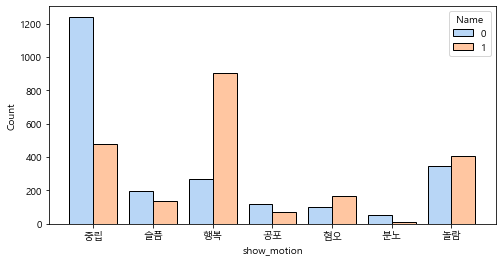

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(8,4))
ax = sns.histplot(data=all_chat, x='show_motion', hue='Name', multiple="dodge", shrink=.8, palette='pastel')
all_chat[['Name', 'Time', 'Chat', 'show_motion']][230:2040]